# Косенко Никита
## Лабораторная работа №2, вариант 9

In [1508]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

Подключаем данные

In [1509]:
data = pd.read_csv('data_ml_v2-09.csv')
X = data[['x1', 'x2']]
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)
data

,x1,x2,label
0,2.09900,1.18550,1
1,4.08970,2.34480,1
2,2.29870,1.53440,1
3,2.31340,0.83835,1
4,2.77860,0.52184,1
...,...,...,...
495,0.74488,4.03800,4
496,0.97697,3.33700,4
497,-0.38525,5.38230,4
498,1.28370,2.65840,4


### Задание 1
Оценить ковариационные матрицы обучающих данных для каждого класса при различных предположениях:

a) ковариационные матрицы всех классов равные, скалярные

б) равные, диагональные

в) различные, скалярные

г) различные, диагональные

д) равные

е) различные

Визуализировать матрицы для каждого случая.

In [1510]:
# Получаем уникальные классы
classes = y_train.unique()

# Инициализируем словарь для хранения ковариационных матриц
cov_matrices = {}

In [1511]:
# a) ковариационные матрицы всех классов равные, скалярные
cov_equal_scalar = np.cov(X_train.T) * np.eye(X_train.shape[1])
cov_matrices['equal, scalar'] = cov_equal_scalar

In [1512]:
# б) равные, диагональные
cov_equal_diagonal = np.diag(np.var(X_train, axis=0))
cov_matrices['equal, diagonal'] = cov_equal_diagonal

In [1513]:
# в) различные, скалярные
for cls in classes:
    cov_matrices[f'different, scalar, class {cls}'] = np.cov(
        X_train[y_train == cls].T) * np.eye(X_train.shape[1])

In [1514]:
# г) различные, диагональные
for cls in classes:
    cov_matrices[f'different, diagonal, class {cls}'] = np.diag(
        np.var(X_train[y_train == cls], axis=0))

In [1515]:
# д) равные
cov_equal = np.cov(X_train.T)
cov_matrices['equal'] = cov_equal

In [1516]:
# е) различные
for cls in classes:
    cov_matrices[f'different, class {cls}'] = np.cov(X_train[y_train == cls].T)

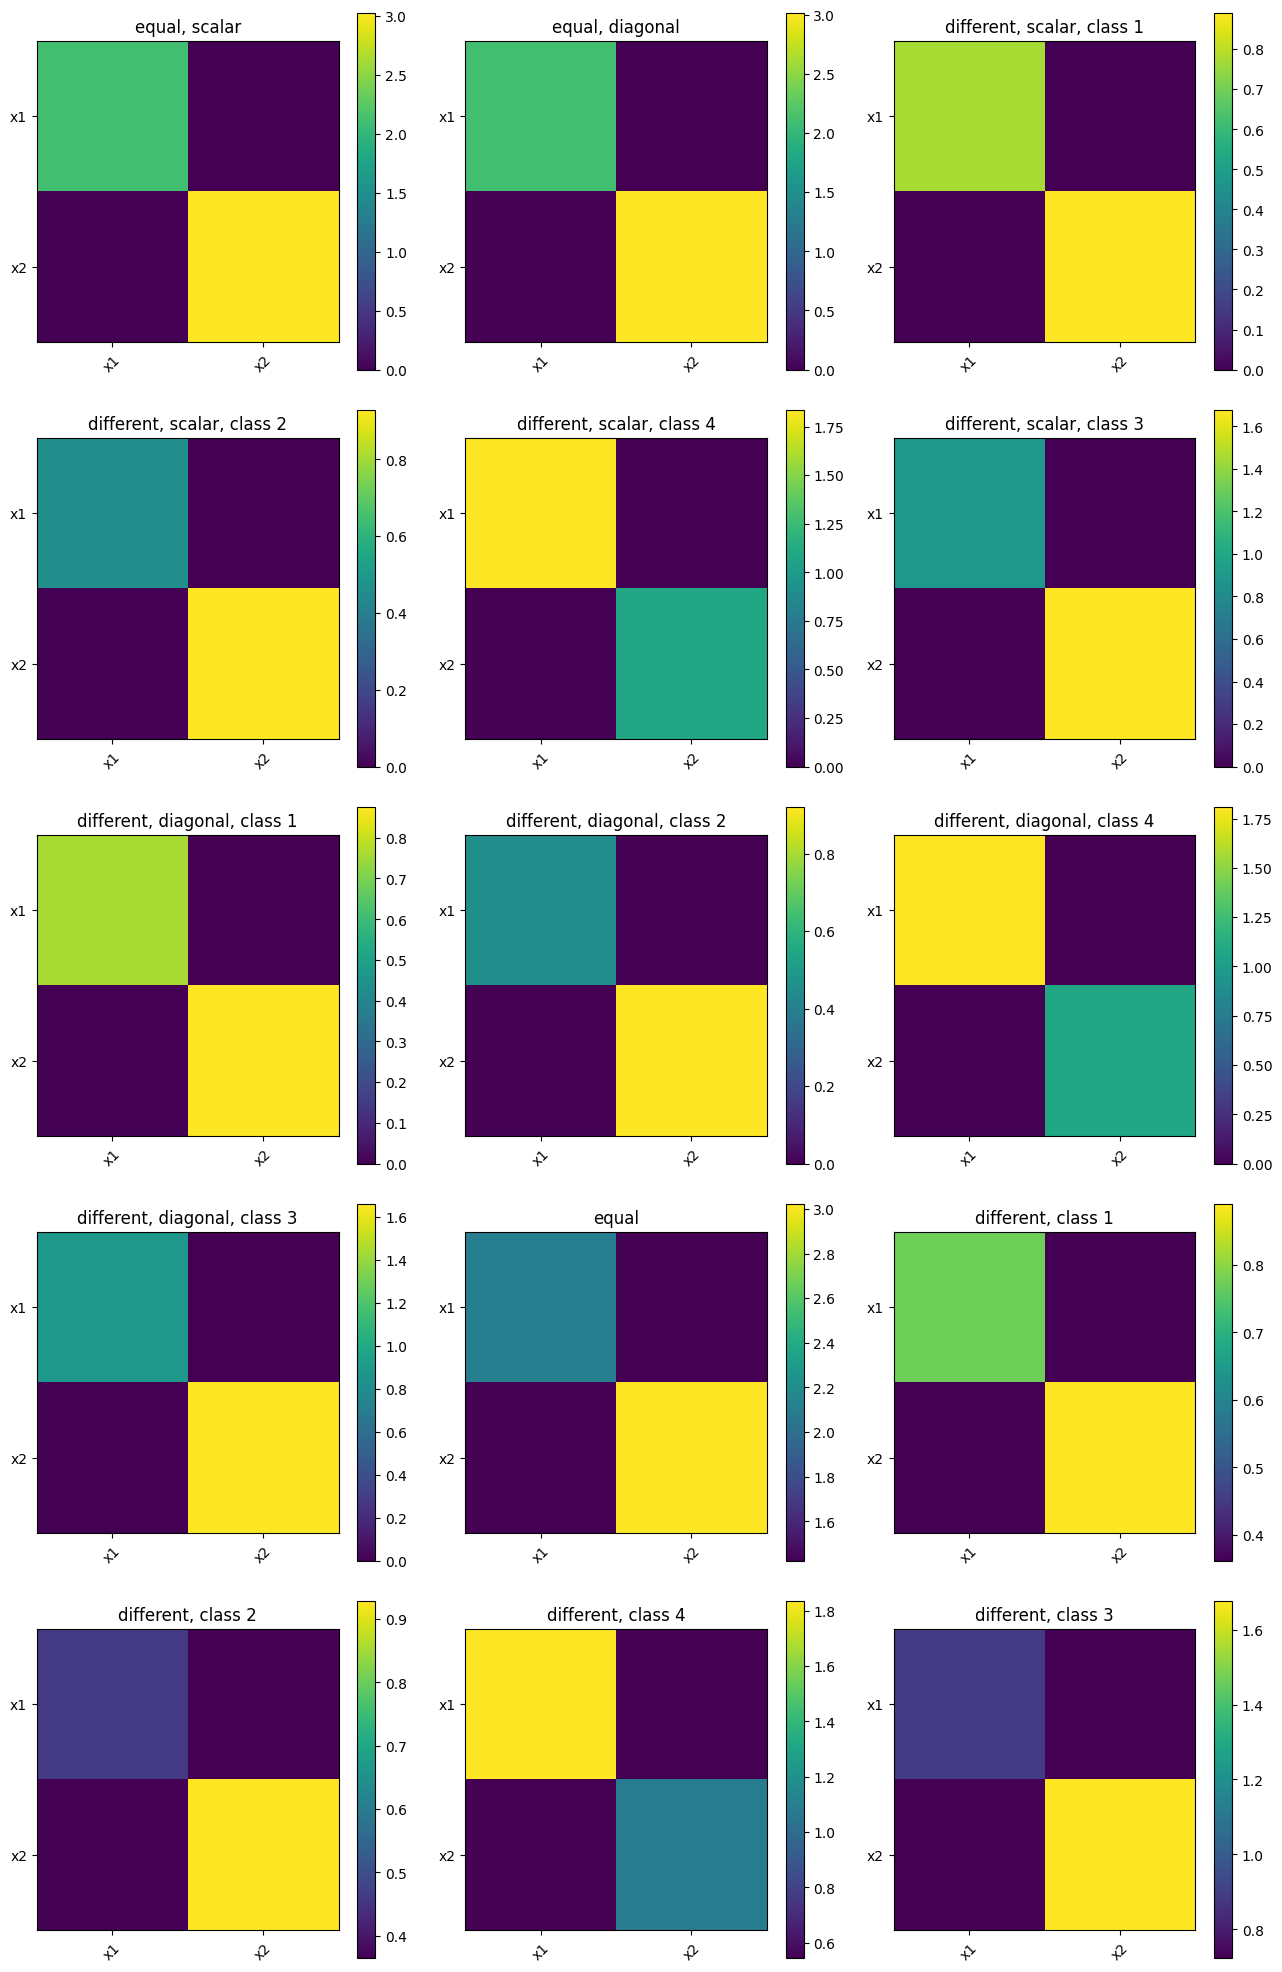

In [1517]:

# Визуализация ковариационных матриц
num_matrices = len(cov_matrices)
rows = (num_matrices // 3) + (num_matrices %
                              3 > 0)  # Определяем количество строк
plt.figure(figsize=(13, 4 * rows))
for i, (key, cov_matrix) in enumerate(cov_matrices.items()):
    plt.subplot(rows, 3, i + 1)
    plt.imshow(cov_matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title(key)
    plt.xticks(range(cov_matrix.shape[0]), ['x1', 'x2'], rotation=45)
    plt.yticks(range(cov_matrix.shape[0]), ['x1', 'x2'])

plt.tight_layout()
plt.show()

### Задание 2
Рассчитать классификационные очки байесовских классификаторов, обученных при предположениях а-е пункта 1 для примеров обучающей и тестовой выборок. Априорные вероятности классов считать равными, классификационные очки классификаторов полагать равными апостериорным вероятностям классов.

Реализуем классификатор. Поскольку классов 4, а априорные вероятности считаем равными,то для каждого класса априорная вероятность равна 1/4.
Поскольку классификатор байессовский, теорема Байеса применима:
$$
P(C_k | \mathbf{x}) = \frac{P(\mathbf{x} | C_k) P(C_k)}{P(\mathbf{x})}
$$

Где:
- $ P(C_k | \mathbf{x}) $ — апостериорная вероятность класса $ C_k $ при условии наблюдения $ \mathbf{x} $.
- $ P(\mathbf{x} | C_k) $ — правдоподобие (likelihood) наблюдения $ \mathbf{x} $ при условии класса $ C_k $.
- $ P(C_k) $ — априорная вероятность класса $ C_k $.
- $ P(\mathbf{x}) $ — нормализующая константа, которая может быть вычислена как сумма по всем классам.

#### Нормальный Байесовский Классификатор
Формула для правдоподобия $ P(\mathbf{x} | C_k) $ в нормальном классификаторе выглядит следующим образом:

$$
P(\mathbf{x} | C_k) = \frac{1}{(2\pi)^{d/2} |\Sigma_k|^{1/2}} \exp\left(-\frac{1}{2} (\mathbf{x} - \mu_k)^T \Sigma_k^{-1} (\mathbf{x} - \mu_k)\right)
$$

Где:
- $ d $ — количество признаков (размерность).
- $ \mu_k $ — вектор средних значений признаков для класса $ C_k $.
- $ \Sigma_k $ — ковариационная матрица для класса $ C_k $.
- $ | \Sigma_k | $ — определитель ковариационной матрицы.
- $ \Sigma_{k^{-1}} $ — обратная ковариационная матрица.

---

#### Общая Формула для Классификации

Для классификации, мы выбираем класс $ C_k $, который максимизирует апостериорную вероятность:

$$
\hat{C} = \arg\max_{C_k} P(C_k | \mathbf{x}) = \arg\max_{C_k} P(\mathbf{x} | C_k) P(C_k)
$$

In [1518]:
class NormalBayesClassifier:
    def __init__(self, covariance):
        self.means = {}
        self.priors = {}
        self.classes = None
        self.covariance = covariance  # Одна ковариационная матрица для всех классов

    def fit(self, X, y):
        self.classes = np.unique(y)
        for cls in self.classes:
            X_cls = X[y == cls]
            self.means[cls] = X_cls.mean(axis=0)
            self.priors[cls] = 0.25

    def predict_all(self, X): # predict all the observations
        predicts = []
        classes = []
        for x in zip(X['x1'], X['x2']):
            p, c = self.predict(x)
            predicts.append(p)
            classes.append(c)
        return predicts, classes


    def predict(self, x):# predict the class and posteriors of one observation
        posteriors = []
        for cls in self.classes:
            log_prior = np.log(self.priors[cls]) # log of prior
            likelihood = self._multivariate_gaussian(x, self.means[cls], self.covariance)
            log_likelihood = np.log(likelihood) # log of likelihood
            posterior = np.exp(log_prior + log_likelihood)
            posteriors.append(posterior)
        return posteriors , self.classes[np.argmax(posteriors, axis=0)]

    def _multivariate_gaussian(self, x, mean, cov):
        d = 2 # number of features
        cov_inv = np.linalg.inv(cov) # dimention is 2 × 2
        norm_const = 1 / (2 * np.pi)**(d/2) * np.sqrt(np.linalg.det(cov))
        centered = x - mean # dimention is 2 × 1
        # for transposed centered dimention is 1 × 2
        i = np.dot(centered.T, cov_inv)
        p = np.exp(-0.5 * np.dot(i, centered))
        return norm_const * p

Получение классификационных очков

In [1519]:
classifiers = {k:NormalBayesClassifier(v) for k, v in cov_matrices.items()}
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    train_scores, train_res = clf.predict_all(X_train)
    test_scores, test_res = clf.predict_all(X_test)
    print(f'Классификатор: {name}')
    print(f'Классификационные очки на обучающей выборке: \n{train_scores}')
    print(f'Классификационные очки на тестовой выборке: \n{test_scores}')
    print()

Классификатор: equal, scalar
Классификационные очки на обучающей выборке: 
[[np.float64(0.039263566095300906), np.float64(0.04014496283996464), np.float64(0.08191080777412163), np.float64(0.03679694848165878)], [np.float64(0.02025664157800341), np.float64(0.06428513985971297), np.float64(0.07816619043544508), np.float64(0.03966293731421697)], [np.float64(0.09744344005394896), np.float64(0.001456763297435684), np.float64(0.035252935279054896), np.float64(0.021929383937683587)], [np.float64(0.09235128868016299), np.float64(0.0008533604249594869), np.float64(0.027416831331033634), np.float64(0.017744270499798494)], [np.float64(0.0028782520480407333), np.float64(0.07682845823348487), np.float64(0.03928160970989987), np.float64(0.029225952678872017)], [np.float64(0.05243285661735491), np.float64(0.014378941225563265), np.float64(0.09368822353619839), np.float64(0.08170943687586191)], [np.float64(0.09579693111425659), np.float64(0.00319655766040169), np.float64(0.03901307209382562), np.float

### Задание 3
В исходном пространстве признаков изобразить области классов (закрасить разными цветами), формируемые каждым из обученных классификаторов. Нанести на диаграммы границы классов и данные из обучающей и тестовой выборок. На отдельной диаграмме изобразить все границы классов, формируемые построенными классификаторами.

### Задание 4
Рассчитать точности (accuracy) построенных классификаторов на обучающей и тестовой выборках, представить данные в графическом виде (bar charts).

### Задание 5
Для каждого классификатора построить micro-averaged и macro-averaged ROC-кривые и PR-кривые на обучающей и тестовой выборках и рассчитать micro-averaged и macro-averaged ROC AUC и PR AUC на обучающей и тестовой выборках.

### Задание 6
Сделать выводы о влиянии предположений о модели обучающих данных на точность байесовской классификации.